[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/instats_gp/blob/main/sessions/Session_1.ipynb)

# Session 1: Introduction to Gaussian Processes and PyMC

## Learning Objectives

By the end of this session, you will be able to:

- Understand what Bayesian non-parametric models are and how Gaussian processes fit into this framework
- Connect the familiar concept of multivariate normal distributions to the more general idea of Gaussian processes
- Learn the basics of PyMC and how to implement simple models
- Understand the roles of mean and covariance functions in defining a GP's behavior
- Build and fit your first GP model using real data

## LLM-Assisted Exercises

Throughout these notebooks, you'll notice sections marked with 🤖. These are **LLM-assisted exercises** where you'll practice using large language models (like ChatGPT, Claude, or your favorite coding assistant) to help you implement GP concepts. This approach reflects modern data science practice: knowing *what* you want to accomplish and *how* to verify it is often more important than memorizing every implementation detail.

The exercises are designed to help you develop the skill of effectively communicating with AI assistants—a critical ability in today's data science workflow. You'll learn to write clear prompts, test implementations, and validate results, building both your GP expertise and your collaborative coding skills.

## Section 1.1: Introduction and Setup

### What Does "Non-Parametric" Mean in a GP Context?

When we talk about Gaussian processes being "non-parametric," we're not saying they have no parameters—that would be confusing! Instead, we mean that GPs don't assume a fixed functional form with a finite number of parameters. 

Think about it this way: in linear regression, you commit to a straight line (or hyperplane) defined by a slope and intercept. You're making a strong assumption about the shape of your function before seeing the data. With a GP, you're defining a *distribution over functions*. The data then tells you which functions from this distribution are most plausible.

This flexibility makes GPs incredibly powerful for modeling complex, unknown relationships. The "parameters" in a GP are actually hyperparameters that control properties like smoothness and lengthscale—they shape the space of possible functions rather than defining a single function.

In [1]:
import pymc as pm
import numpy as np
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import arviz as az
import plotly.io as pio
from scipy import stats

DATA_DIR = "../data/"

RNG = np.random.default_rng(RANDOM_SEED:= 8675309)

pio.templates.default = "plotly_white"

print(f"PyMC version: {pm.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Polars version: {pl.__version__}")

PyMC version: 5.25.1
NumPy version: 2.3.3
Polars version: 1.35.1


Everything should import cleanly and you should see version numbers printed above. If you encounter any import errors, make sure your environment is set up correctly with PyMC 5.16+, NumPy 2.x, and Polars 1.x.

Notice that we're setting `RANDOM_SEED` right at the start. Reproducibility is crucial in Bayesian workflows—you want to be able to recreate your results exactly, especially when debugging or sharing your work with colleagues.

### ArviZ for Posterior Analysis

Throughout this workshop, we'll use **ArviZ first** for all posterior analysis, diagnostics, and visualization. ArviZ provides battle-tested functions for computing summaries, visualizing distributions, and performing model checking. While you could manually extract posterior samples and create custom plots, ArviZ handles edge cases correctly and provides consistent, publication-quality output.

## Section 1.2: Bayesian Inference Primer

Before we learn the PyMC API or dive into Gaussian processes, let's build intuition for the Bayesian framework itself. Understanding how we update beliefs with data is fundamental to everything that follows.

### The Three-Step Bayesian Workflow

Every Bayesian analysis follows the same three-step pattern:

1. **Specify a probability model**: Assign probability distributions to all unknowns—parameters, predictions, even missing data
2. **Calculate the posterior distribution**: Update our beliefs by combining prior knowledge with observed data  
3. **Check and interpret**: Validate the model and draw conclusions

This workflow applies whether we're estimating a simple proportion or building complex Gaussian process models.

### Bayes' Theorem: The Foundation

At its heart, Bayesian inference is about updating beliefs with data. We start with prior knowledge (the prior), observe data (the likelihood), and combine them through multiplication to get updated knowledge (the posterior):

$$P(\theta | y) \propto P(y | \theta) P(\theta)$$

**Reading this equation aloud:**
- **Posterior** ∝ **Likelihood** × **Prior**
- What we believe about $\theta$ after seeing data is proportional to how likely the data would be under different $\theta$ values, weighted by what we believed before

This seemingly simple equation is incredibly powerful. Think of it visually: if your prior was a curve and the likelihood was another curve, the posterior is their product—peaks where both agree, valleys where they disagree.

The proportionality constant is just a normalization factor ensuring probabilities sum to one—important mathematically, but not essential for building intuition.

### A Concrete Example: Estimating a Batting Average

Let's work through a simple analytical example to see Bayesian updating in action. Imagine we want to estimate the true batting average $\theta$ for a baseball player—the probability they get a hit in any given plate appearance.

**Setup**: We observe a player get 3 hits in their first 5 plate appearances. What can we infer about their true batting average $\theta$?

**Step 1: Specify the model**
- **Likelihood** (Binomial): Number of hits follows $\text{Binomial}(n=5, p=\theta)$
- **Prior** (Beta): We start with a uniform prior, $\text{Beta}(1, 1)$—maximum uncertainty about $\theta$

**Step 2: Compute the posterior**

The beautiful thing about the Beta-Binomial combination is that we can calculate the posterior analytically—no fancy algorithms needed! This is called *conjugacy*.

The posterior is $\text{Beta}(1+3, 1+2) = \text{Beta}(4, 3)$. Notice how the parameters simply add:
- Prior "hits": 1 -> Posterior: 1 + 3 = 4
- Prior "outs": 1 -> Posterior: 1 + 2 = 3

Let's visualize this updating process:

In [2]:
# Setup: 3 hits from 5 plate appearances
n, y = 5, 3
theta = np.linspace(0, 1, 200)

# Prior: Beta(1, 1) = Uniform
prior = stats.beta.pdf(theta, 1, 1)

# Likelihood: Binomial (normalized for visibility)
likelihood = theta**y * (1-theta)**(n-y)
likelihood = likelihood / likelihood.max()

# Posterior: Beta(1+y, 1+n-y) = Beta(4, 3)
posterior = stats.beta.pdf(theta, 1+y, 1+n-y)

# Visualize
fig = go.Figure()
fig.add_trace(go.Scatter(x=theta, y=prior, name='Prior',
                         mode='lines', line=dict(color='gray', width=2, dash='dash')))
fig.add_trace(go.Scatter(x=theta, y=likelihood, name='Likelihood (normalized)',
                         mode='lines', line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=theta, y=posterior, name='Posterior',
                         mode='lines', line=dict(color='red', width=3)))

fig.update_layout(
    title='Bayesian Updating: Prior × Likelihood = Posterior',
    xaxis_title='θ (batting average)',
    yaxis_title='Probability Density',
    showlegend=True
)
fig.show()

# Posterior mean
posterior_mean = (1 + y) / (1 + 1 + n)
print(f"\nPosterior mean: {posterior_mean:.3f}")
print(f"This is between our prior mean (0.5) and the observed proportion ({y/n:.3f})")


Posterior mean: 0.571
This is between our prior mean (0.5) and the observed proportion (0.600)


Notice the beautiful interplay:

- The **prior** (gray dashed) is flat—we started with no preference for any value of $\theta$
- The **likelihood** (blue) peaks at the observed proportion (3/5 = 0.6)—this is what the data alone suggests
- The **posterior** (red) is their product, peaked near the likelihood but slightly regularized by the prior

With only 5 plate appearances, there's still substantial uncertainty. Let's see what happens as we collect more data:


In [3]:
# Show how posterior narrows with more data
# True batting average is 0.250
sample_sizes = [5, 20, 100]
true_average = 0.250

fig = go.Figure()

for n in sample_sizes:
    # Generate plausible number of hits given true average
    y = RNG.binomial(n, true_average)
    posterior = stats.beta.pdf(theta, 1+y, 1+n-y)
    fig.add_trace(go.Scatter(
        x=theta, y=posterior,
        name=f'n={n}, y={y}',
        mode='lines', line=dict(width=2)
    ))

fig.add_vline(x=true_average, line_dash="dash", line_color="green", 
              annotation_text=f"True average: {true_average}", 
              annotation_position="top right")

fig.update_layout(
    title='Posterior Distribution Narrows with More Data',
    xaxis_title='θ (batting average)',
    yaxis_title='Posterior Density',
    showlegend=True
)
fig.show()

This progression beautifully illustrates Bayesian learning in action:

- With **5 plate appearances**, the posterior is wide and centered around 0.6—our small sample was misleading!
- With **20 plate appearances**, uncertainty decreases substantially and the posterior begins moving toward the true average
- With **100 plate appearances**, the posterior becomes very sharp and concentrates tightly around the true batting average of 0.250

This demonstrates a crucial insight: **early observations can be misleading, but as we accumulate more data, the truth emerges**. A player going 3-for-5 in their first few at-bats might look like a .600 hitter (or a 0.100 hitter!), but by 100 at-bats, their true talent level becomes clear.

The posterior mean is always a weighted average of the prior and the data, with the data getting more weight as sample size grows. This is Bayesian learning in action—prior beliefs get updated, and eventually overwhelmed, by evidence. The "hot start" of 3-for-5 gets appropriately downweighted as more representative data accumulates.

### Why This Matters for Gaussian Processes

This same Bayesian framework powers GP modeling. Instead of updating beliefs about a single parameter $\theta$, we'll update beliefs about entire *functions*. The prior becomes a distribution over functions (specified by mean and covariance), the likelihood describes how data relates to function values, and the posterior gives us updated beliefs about which functions are plausible.

But first, we need to learn how to implement Bayesian models in PyMC. Let's dive into the API with a real dataset.

## Section 1.3: Introduction to PyMC with Real Data

Now that we understand the Bayesian framework conceptually, let's learn how to implement it using PyMC. We'll start with the simplest possible model: estimating the distribution of a single continuous variable.

### The Data: Baseball Launch Angles

We'll use real baseball data from the `fastball_bat_angles.csv` dataset. When a batter makes contact with a fastball, the ball leaves the bat at a particular **launch angle**—the vertical angle relative to horizontal. Launch angle is crucial for hitting outcomes: too low and you hit a ground ball, too high and you pop out, just right and you might hit a home run.

Let's focus on a single player and estimate the distribution of their launch angles. We'll use this to learn PyMC syntax before moving to more complex models.


In [4]:
df = pl.read_csv(DATA_DIR + 'fastball_bat_angles.csv')

print("Sample of available batters:")
print(df.select('batter_name').unique().head(10))

harper = df.filter(pl.col('batter_name') == 'Harper, Bryce')
print(f"\nBryce Harper: {harper.shape[0]} fastball contacts")

launch_angles = harper['launch_angle'].to_numpy()

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=launch_angles,
    nbinsx=30,
    name='Observed Launch Angles',
    marker_color='steelblue'
))
fig.update_layout(
    title='Bryce Harper: Launch Angle Distribution',
    xaxis_title='Launch Angle (degrees)',
    yaxis_title='Count',
    showlegend=False
)
fig.show()

print(f"\nSummary statistics:")
print(f"Mean: {launch_angles.mean():.1f}°")
print(f"Std Dev: {launch_angles.std():.1f}°")
print(f"Range: [{launch_angles.min():.1f}°, {launch_angles.max():.1f}°]")

Sample of available batters:
shape: (10, 1)
┌───────────────────┐
│ batter_name       │
│ ---               │
│ str               │
╞═══════════════════╡
│ Gallagher, Cam    │
│ Odor, Rougned     │
│ Brinson, Lewis    │
│ Castillo, Diego   │
│ Cabrera, Asdrubal │
│ Gurriel, Lourdes  │
│ Shewmake, Braden  │
│ Garcia, Adolis    │
│ Rogers, Jake      │
│ Acuna, Ronald     │
└───────────────────┘

Bryce Harper: 727 fastball contacts



Summary statistics:
Mean: 22.6°
Std Dev: 27.7°
Range: [-67.4°, 84.5°]


The distribution looks roughly bell-shaped, though perhaps not perfectly symmetric. A normal distribution seems like a reasonable starting point.

### Building Your First PyMC Model

Let's estimate the mean and standard deviation of Harper's launch angle distribution. The model is simple:

$$\begin{aligned}
\mu &\sim \text{Normal}(30, 20) \\
\sigma &\sim \text{HalfNormal}(20) \\
y_i &\sim \text{Normal}(\mu, \sigma)
\end{aligned}$$

We're saying:
- The mean launch angle $\mu$ is probably around 30° (that's a good launch angle), but we're quite uncertain (SD of 20°)
- The standard deviation $\sigma$ is positive, probably not huge—maybe around 20° or less
- Each observed launch angle is drawn from a normal distribution with these parameters

Here's how to write this in PyMC:

In [ ]:
with pm.Model() as launch_model:
    # Priors
    mu = pm.Normal('mu', mu=30, sigma=20)
    sigma = pm.HalfNormal('sigma', sigma=20)
    
    # Likelihood
    y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=launch_angles)
    
    # Sample from the posterior
    trace = pm.sample(1000, tune=1000, nuts_sampler='nutpie',
                      random_seed=RNG)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,1.18,3
,2000,0,1.10,3
,2000,0,1.22,3
,2000,0,1.33,3


Let's unpack what just happened:

1. `with pm.Model() as launch_model:` creates a model context. All variables defined inside this block are part of the model.

2. `pm.Normal('mu', mu=30, sigma=20)` defines our prior for the mean. The first argument is the variable name, then come the parameters.

3. `pm.HalfNormal('sigma', sigma=20)` defines our prior for the standard deviation. HalfNormal is like Normal but constrained to be positive—perfect for scale parameters.

4. `pm.Normal('y', mu=mu, sigma=sigma, observed=launch_angles)` defines the likelihood. The `observed=` argument connects the model to our actual data.

5. `pm.sample()` runs MCMC sampling to approximate the posterior distribution. We'll learn more about this later—for now, just know it's finding the parameter values most consistent with our data and priors.

Now let's examine what we learned:

Posterior Summary:
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     22.664  1.040  20.706   24.648      0.015    0.017    4548.0    3085.0   
sigma  27.741  0.719  26.416   29.122      0.011    0.012    4606.0    3125.0   

       r_hat  
mu       1.0  
sigma    1.0  


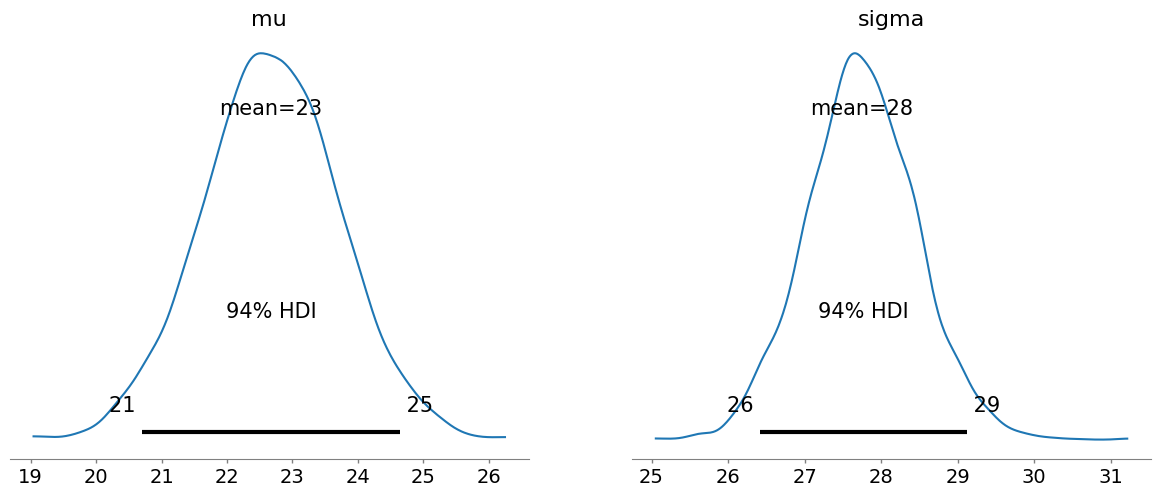

In [6]:
# Summary table
print("Posterior Summary:")
print(az.summary(trace, var_names=['mu', 'sigma']))

# Visualize posteriors
az.plot_posterior(trace, var_names=['mu', 'sigma']);

ArviZ's `summary` function provides comprehensive posterior statistics including:
- **mean**: The posterior mean estimate
- **sd**: The posterior standard deviation (uncertainty)
- **hdi_3%** and **hdi_97%**: The 94% Highest Density Interval—the narrowest interval containing 94% of posterior probability
- **r_hat**: Convergence diagnostic (should be < 1.01)
- **ess_bulk** and **ess_tail**: Effective sample size metrics

The `plot_posterior` function creates clean, informative visualizations showing the posterior distribution along with the mean and HDI automatically computed and displayed.

Notice how much narrower the posterior is compared to our prior—the data has substantially reduced our uncertainty about Harper's true mean launch angle.

### Posterior Predictive Checks

A crucial part of the Bayesian workflow is asking: "If this model is correct, would it generate data that looks like what we actually observed?" This is called a **posterior predictive check**.

The **posterior predictive distribution** integrates over our uncertainty in the parameters to generate predictions for new data. Mathematically, it's defined as:

$$p(\tilde{y} | y) = \int p(\tilde{y} | \theta) p(\theta | y) \, d\theta$$

Reading this equation aloud:
- The probability of new data $\tilde{y}$ given our observed data $y$
- Equals the integral over all parameter values $\theta$
- Of the likelihood of new data under those parameters, $p(\tilde{y} | \theta)$
- Weighted by the posterior probability of those parameters, $p(\theta | y)$

This is powerful: rather than making predictions with a single "best" parameter estimate (which ignores uncertainty), we're averaging predictions across all plausible parameter values, weighted by their posterior probability. This naturally propagates parameter uncertainty into our predictions.

In our launch angle example, we're integrating over the posterior distributions of $\mu$ and $\sigma$ to simulate new datasets and compare them to our observed data:

Sampling: [y]


Output()

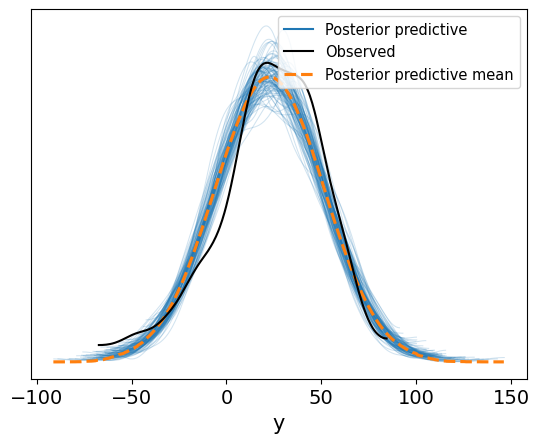

In [7]:
with launch_model:
    # Sample from the posterior predictive distribution
    trace.extend(pm.sample_posterior_predictive(trace, random_seed=RNG))

# Use ArviZ's built-in posterior predictive check plot
az.plot_ppc(trace, num_pp_samples=100);

ArviZ's `plot_ppc` function creates an intuitive visualization comparing the posterior predictive samples (light blue curves) with the observed data (solid black curve). The orange dashed line shows the mean of all posterior predictive samples.

Looking critically at this plot reveals a fundamental model misspecification. The observed data (black curve) sits at the edge or even outside the envelope of posterior predictive samples in several regions:

- The observed data shows clear **asymmetry/skewness** - there's a longer tail toward negative values
- Our normal model is **symmetric by construction**, so none of the posterior predictive samples can capture this skewness
- The observed peak is sharper and more concentrated than the symmetric normal distributions can produce
- In some regions of the distribution (particularly the tails), the observed data appears to be a relatively **extreme** or implausible draw from our model

This is model checking doing its job: revealing that our choice of a normal likelihood is questionable. The data appear somewhat skewed, but we forced it into a symmetric distribution. `

Thus, **posterior predictive checks can reveal model inadequacies even when parameter estimates seem reasonable**. Just because we can fit parameters doesn't mean the model structure is appropriate. In practice, for pedagogical simplicity, we're accepting this limitation—but in a real analysis, we'd explore alternative likelihood functions.

This workflow—specify model, fit, check, and iterate—is fundamental to Bayesian modeling and will be our pattern throughout this workshop.

### 🤖 EXERCISE: Compare Launch Angles Across Batters

Now that you've seen the basic workflow, practice it with different players.

In [ ]:
# Use your LLM to help complete this comparison

def compare_batters(batter_names, df):
    """
    Fit a joint launch angle model for multiple batters and compare posteriors.
    
    Parameters:
    -----------
    batter_names : list of str
        Names of batters to compare (e.g., ['Harper, Bryce', 'Alonso, Pete'])
    df : polars DataFrame
        The fastball bat angles dataset
        
    Returns:
    --------
    results : fig
        Figure object containing the forest plot comparing posterior means

    """
    # YOUR LLM-ASSISTED CODE HERE
    pass

# Test with a few batters
# batters = ['Harper, Bryce', 'Alonso, Pete', 'Tucker, Kyle']
# results = compare_batters(batters, df)

## Section 1.4: Multivariate Normal Models

So far we've modeled single variables in isolation—Harper's launch angle as a univariate distribution. But real data often contains multiple related measurements that vary together. Before we extend to Gaussian processes (which model infinite-dimensional relationships), let's see how to model joint distributions of multiple variables using the multivariate normal distribution.

A **multivariate normal distribution** lets us model the joint distribution of multiple variables, capturing how they covary. This is also where PyMC's **coordinate system** shines. Coordinates (`coords`) let us give meaningful names to dimensions in our models, improving readability and enabling advanced features.

### Attack Angle and Launch Angle

When a batter swings, two angles matter:
- **Attack angle**: The vertical angle of the bat's path as it moves through the hitting zone
- **Launch angle**: The vertical angle of the ball as it leaves the bat

Intuitively, these should be related—if you swing with a more upward bat path (higher attack angle), you're more likely to hit the ball upward (higher launch angle). Let's model their joint distribution.

![Batting Angles](images/batting_angles.jpg)


In [ ]:
# Filter to observations with BOTH attack_angle and launch_angle
df_both = df.filter(pl.col('attack_angle').is_not_null())

print(f"Observations with both angles: {df_both.shape[0]}")
print(f"Original dataset: {df.shape[0]}")
print(f"Fraction with attack angle data: {df_both.shape[0]/df.shape[0]:.1%}")

# Stack into a (n_obs, 2) array
angles = np.column_stack([
    df_both['attack_angle'].to_numpy(),
    df_both['launch_angle'].to_numpy()
])

print(f"\nData shape: {angles.shape}")
print(f"Attack angle range: [{angles[:, 0].min():.1f}, {angles[:, 0].max():.1f}]")
print(f"Launch angle range: [{angles[:, 1].min():.1f}, {angles[:, 1].max():.1f}]")

# Visualize the joint distribution
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=angles[:, 0],
    y=angles[:, 1],
    mode='markers',
    marker=dict(size=3, opacity=0.3, color='steelblue'),
    name='Observed'
))
fig.update_layout(
    title='Joint Distribution of Attack Angle and Launch Angle',
    xaxis_title='Attack Angle (degrees)',
    yaxis_title='Launch Angle (degrees)',
    width=600, height=500
)
fig.show()



There's a clear positive relationship! Higher attack angles tend to produce higher launch angles, though there's substantial scatter.

### Building a Multivariate Normal Model

A bivariate normal distribution is characterized by:
- A **mean vector** $\boldsymbol{\mu} = [\mu_{\text{attack}}, \mu_{\text{launch}}]$
- A **covariance matrix** $\boldsymbol{\Sigma}$ that captures variances and covariance:

$$\boldsymbol{\Sigma} = \begin{bmatrix}
\sigma_{\text{attack}}^2 & \rho \sigma_{\text{attack}} \sigma_{\text{launch}} \\
\rho \sigma_{\text{attack}} \sigma_{\text{launch}} & \sigma_{\text{launch}}^2
\end{bmatrix}$$

where $\rho$ is the correlation coefficient.

### The LKJ Prior for Correlation Matrices

In PyMC, we'll use the **LKJ prior** for the correlation matrix—a flexible prior distribution specifically designed for correlation matrices. The LKJ (Lewandowski-Kurowicka-Joe) prior is elegant because it's defined directly over valid correlation matrices, ensuring our model only considers mathematically valid values.

The key parameter is **eta** ($\eta$), which controls how much we favor correlations near zero:

- **eta = 1**: Uniform distribution over all possible correlations (no preference for any particular correlation structure)
- **eta > 1**: Increasingly favors correlations near zero (mild skepticism of strong correlations)
- **eta < 1**: Favors extreme correlations near -1 or +1 (rarely used in practice)

We'll use **eta = 2** as a mildly skeptical default—we don't assume strong correlations between variables unless the data provides clear evidence. This acts as a form of regularization, preventing the model from overfitting to spurious correlations in small datasets.

We'll also use coordinates to make the model readable:

In [ ]:
# Define coordinates
COORDS = {
    'variable': ['attack_angle', 'launch_angle'],
    'obs': np.arange(angles.shape[0])
}

with pm.Model(coords=COORDS) as mvn_model:
    # Mean vector (one mean per variable)
    mu = pm.Normal('mu', mu=0, sigma=30, dims='variable')
    
    # Correlation matrix with LKJ prior (eta=2 is weakly informative)
    # Standard deviations for each variable
    chol, corr, stds = pm.LKJCholeskyCov(
        'chol', n=2, eta=2.0, 
        sd_dist=pm.HalfNormal.dist(sigma=20, shape=2),
        compute_corr=True
    )
    
    # Multivariate normal likelihood
    pm.MvNormal('angles', mu=mu, chol=chol,
                      observed=angles, dims=('obs', 'variable'))
    
    # Sample
    trace_mvn = pm.sample(500, tune=500, nuts_sampler='nutpie',
                          random_seed=RNG)

Let's examine what we learned about the means, standard deviations, and correlation:


In [ ]:
# Summary table
print("Posterior Summary:")
print(az.summary(trace_mvn, var_names=['mu', 'chol_stds', 'chol_corr']))

# Visualize mean and standard deviation estimates
az.plot_posterior(trace_mvn, var_names=['mu', 'chol_stds']);

In [ ]:
# Visualize the correlation posterior using ArviZ
az.plot_posterior(
    trace_mvn, 
    var_names=['chol_corr'],
    coords={'chol_corr_dim_0': 0, 'chol_corr_dim_1': 1}
);

In [ ]:
chol.shape.eval()

ArviZ's `plot_posterior` automatically computes and displays the posterior mean and credible interval for the correlation coefficient. The positive correlation confirms our intuition: attack angle and launch angle are positively related. When batters swing upward, they tend to hit the ball upward.

## Section 1.5: From Multivariate Normals to Gaussian Processes

### Building Intuition: Functions as Infinite-Dimensional Vectors

Here's the key insight that unlocks Gaussian processes: if you squint just right, a function is just a really long vector—infinitely long, in fact. At every point $x$ in the input space, the function has a value $f(x)$. You can think of $f$ as an infinite-dimensional vector, with one entry for each possible $x$.

Now, you already know what a multivariate normal (MVN) distribution is—it's a probability distribution over vectors. A Gaussian process is simply the natural extension of an MVN distribution to this infinite-dimensional case. It's a distribution over *functions*.

The magic is that we can work with GPs using only finite-dimensional operations. We never actually deal with infinity—we only care about the function values at the specific points where we have (or want) observations.

### The Two Components of a GP

A Gaussian process is completely specified by two functions:
- A **mean function** $m(x)$ that gives the expected value at each point
- A **covariance function** (or kernel) $k(x, x')$ that describes how function values at different points relate to each other

We write: $f(x) \sim \mathcal{GP}(m(x), k(x, x'))$

Think of it this way: the mean function tells you where the function is *centered*, while the covariance function tells you how *smooth* it is and how values at different locations are related. Together, they completely define a distribution over functions.

In the next two sections, we'll explore each component in detail—starting with covariance functions (Section 1.6), then mean functions (Section 1.7).

## Section 1.6: Covariance Functions

### The Heart of Gaussian Processes

If the mean function is where your prior belief lives, the covariance function (or kernel) is where the magic happens. The kernel defines the structure, smoothness, and patterns that your GP can express. Choosing the right kernel is often the most important modeling decision you'll make.

A covariance function $k(x, x')$ must satisfy one critical property: it must produce **positive semi-definite covariance matrices** for any set of input points. This ensures that the resulting multivariate normal distributions are valid.

Before we explore PyMC's built-in kernels, let's build intuition by implementing the squared exponential (ExpQuad) kernel ourselves and understanding how it works.

### 🤖 EXERCISE: Implement the ExpQuad Kernel

Let's start by implementing the exponential quadratic (RBF) kernel from scratch. This exercise will help you understand what a covariance function actually does.

The ExpQuad kernel is defined as:

$$k(x, x') = \sigma^2 \exp\left(-\frac{\|x - x'\|^2}{2\ell^2}\right)$$

where $\ell$ is the lengthscale (controls how quickly correlation decays with distance) and $\sigma^2$ is the variance (controls overall scale of function values).

In [ ]:
# Use your LLM to help complete this implementation

# STEP 1: Ask your LLM to help you implement this function
def exp_quad_kernel(X1, X2, lengthscale=1.0, variance=1.0):
    """
    Compute the ExpQuad (RBF/Squared Exponential) covariance matrix.
    
    The ExpQuad kernel is: k(x, x') = variance * exp(-||x - x'||^2 / (2 * lengthscale^2))
    
    Parameters:
    -----------
    X1 : array-like, shape (n_samples_1, n_features)
        First input matrix
    X2 : array-like, shape (n_samples_2, n_features)  
        Second input matrix
    lengthscale : float
        Length scale parameter - controls how quickly correlation decays with distance
    variance : float
        Variance parameter - controls overall scale of function values
        
    Returns:
    --------
    K : array, shape (n_samples_1, n_samples_2)
        Covariance matrix
    """
    pass

# STEP 2: Test your implementation
# Create a simple test case
X_test = np.array([[0.], [1.], [2.]])
K_test = exp_quad_kernel(X_test, X_test, lengthscale=1.0, variance=1.0)

print("Covariance matrix:")
print(K_test)
print("\nProperties to check:")
print(f"1. Symmetric? {np.allclose(K_test, K_test.T)}")
print(f"2. Diagonal values (should be ~{1.0}): {np.diag(K_test)}")
print(f"3. Positive semi-definite? {np.all(np.linalg.eigvals(K_test) >= -1e-10)}")

Great! Let's verify the properties of our kernel:

1. **Symmetric**: The covariance matrix is symmetric because $k(x, x') = k(x', x)$—the distance between two points doesn't depend on order
2. **Diagonal = variance**: Points are perfectly correlated with themselves, so $k(x, x) = \sigma^2 = 1.0$
3. **Positive semi-definite**: All eigenvalues are non-negative, ensuring valid probability distributions

Notice how off-diagonal values decay as points get farther apart. This decay rate is controlled by the lengthscale parameter.

### Visualizing the Kernel Structure

Let's visualize this kernel as a heatmap to understand what it's doing. The kernel matrix tells us how correlated function values are at different input locations:

In [ ]:
# Create a grid of points
X_grid = np.linspace(0, 10, 50)[:, None]
K_grid = exp_quad_kernel(X_grid, X_grid, lengthscale=1.5, variance=1.0)

# Visualize the covariance matrix
fig = px.imshow(K_grid, 
                x=X_grid.flatten(),
                y=X_grid.flatten(),
                color_continuous_scale='Viridis',
                labels=dict(x="x", y="x'", color="Covariance"),
                title="ExpQuad Kernel: How function values covary")
fig.update_layout(width=600, height=500)
fig.show()

Notice the structure: the diagonal is bright (variance = 1.0), meaning each point is perfectly correlated with itself. As you move away from the diagonal, the correlation decays smoothly. This decay rate is controlled by the lengthscale parameter—it determines how far apart two points can be before they become essentially uncorrelated.

The symmetry around the diagonal confirms that our kernel treats distance symmetrically: the correlation between $x=2$ and $x=5$ is the same as between $x=5$ and $x=2$.

### From Covariance Matrix to Functions

Now comes the beautiful connection: we can use this kernel to draw actual functions from a GP prior. Remember, we're just sampling from a multivariate normal distribution!

In [ ]:
# Define input points where we want to evaluate the function
X = np.linspace(0, 10, 100)[:, None]

# Build the covariance matrix
lengthscale = 1.5
variance = 1.0
K = exp_quad_kernel(X, X, lengthscale=lengthscale, variance=variance)

# Add small jitter for numerical stability
K += 1e-8 * np.eye(len(X))

# Zero mean function
mean = np.zeros(len(X))

# Draw sample functions from the GP prior
n_samples = 5
f_samples = RNG.multivariate_normal(mean, K, size=n_samples)

fig = go.Figure()
for i in range(n_samples):
    fig.add_trace(go.Scatter(
        x=X.flatten(),
        y=f_samples[i],
        mode='lines',
        name=f'Sample {i+1}',
        line=dict(width=2),
        opacity=0.7
    ))

fig.update_layout(
    title=f'Functions Drawn from GP Prior (lengthscale={lengthscale}, variance={variance})',
    xaxis_title='x',
    yaxis_title='f(x)',
    showlegend=True
)
fig.show()

These are functions drawn from our GP prior! Each colored line represents one possible function that the GP considers plausible before seeing any data. Notice how smooth they are—that smoothness comes from the ExpQuad kernel.

Here's the beautiful thing: we just drew these functions by sampling from a multivariate normal distribution. The connection is direct:
- The **mean vector** of the MVN is our mean function evaluated at our input points (zero in this case)
- The **covariance matrix** of the MVN is our kernel evaluated at all pairs of input points

This is the heart of Gaussian processes: a GP is just an MVN distribution over function values, with the structure determined by the covariance function.

### Understanding Lengthscale: The Smoothness Dial

The lengthscale parameter is often the most important hyperparameter in a GP model. It controls how quickly the correlation between function values decays as you move apart in input space. Let's visualize its effect:

- **Small lengthscale** (0.5): Function values decorrelate quickly → wiggly, rapidly varying functions
- **Medium lengthscale** (1.5): Moderate correlation decay → smooth but responsive
- **Large lengthscale** (3.0): Function values stay correlated over long distances → very smooth, slowly varying

In [ ]:
lengthscales = [0.5, 1.5, 3.0]

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=[f'lengthscale = {l}' for l in lengthscales])

for idx, ls in enumerate(lengthscales, 1):
    K = exp_quad_kernel(X, X, lengthscale=ls, variance=1.0)
    K += 1e-8 * np.eye(len(X))
    
    samples = RNG.multivariate_normal(np.zeros(len(X)), K, size=3)
    
    for sample in samples:
        fig.add_trace(
            go.Scatter(x=X.flatten(), y=sample, mode='lines',
                      showlegend=False, line=dict(width=1.5)),
            row=1, col=idx
        )

fig.update_xaxes(title_text="x")
fig.update_yaxes(title_text="f(x)", col=1)
fig.update_layout(height=300, width=900,
                  title_text="Effect of Lengthscale on Function Smoothness")
fig.show()

With lengthscale = 0.5, the functions are highly wiggly—they can change direction rapidly. With lengthscale = 3.0, the functions are very smooth and change slowly across the entire domain.

This parameter directly encodes your prior belief about how smooth the underlying function should be. If you're modeling temperature over a day, you might use a larger lengthscale (temperature changes gradually). If you're modeling stock prices, you might need a smaller lengthscale (prices can change rapidly).

The key insight: **lengthscale sets the spatial scale at which the function varies**. It's like setting the "resolution" of patterns the GP can capture.

### Understanding Variance: The Amplitude Dial

While lengthscale controls how smooth functions are, the variance parameter $\sigma^2$ controls their **amplitude**—how far function values can deviate from the mean. Think of it as a volume knob: it scales the magnitude of variations without changing the correlation structure or smoothness.

The variance parameter appears in the kernel as a multiplicative factor. For the ExpQuad kernel:

$$k(x, x') = \sigma^2 \exp\left(-\frac{\|x - x'\|^2}{2\ell^2}\right)$$

Notice that $\sigma^2$ multiplies the entire exponential term, scaling all covariances uniformly. Let's visualize how different variance values affect the functions we can draw from a GP prior:

In [ ]:
variances = [0.2, 1.0, 3.0]

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=[f'variance = {v}' for v in variances])

for idx, var in enumerate(variances, 1):
    K = exp_quad_kernel(X, X, lengthscale=1.5, variance=var)
    K += 1e-8 * np.eye(len(X))

    samples = RNG.multivariate_normal(np.zeros(len(X)), K, size=3)

    for sample in samples:
        fig.add_trace(
            go.Scatter(x=X.flatten(), y=sample, mode='lines',
                      showlegend=False, line=dict(width=1.5)),
            row=1, col=idx
        )

# Use consistent y-axis scale to emphasize amplitude differences
fig.update_xaxes(title_text="x")
fig.update_yaxes(title_text="f(x)", col=1, range=[-6, 6])
fig.update_yaxes(range=[-6, 6], col=2)
fig.update_yaxes(range=[-6, 6], col=3)
fig.update_layout(height=300, width=900,
                  title_text="Effect of Variance on Function Amplitude")
fig.show()

The visualization shows how variance scales the amplitude while preserving smoothness. Notice that the functions wiggle at the same spatial frequency across all three panels—that's because lengthscale is constant at 1.5. What changes is the **magnitude of the wiggles**:

- With variance = 0.2, functions hover close to zero, rarely venturing beyond ±1
- With variance = 1.0, functions explore a moderate range around ±2  
- With variance = 3.0, functions make large excursions, easily reaching ±4 or more

In practical applications, if your data have a particular scale (e.g., temperatures ranging from 10-30°C), the variance should reflect that scale. Standardizing your data often simplifies prior specification by making variance = 1.0 a sensible default.

### Lengthscale vs Variance: Independent Controls

These two parameters work together but control orthogonal aspects of the GP:
- **Lengthscale** ($\ell$): Controls the **spatial scale** of variation (smoothness, correlation range)
- **Variance** ($\sigma^2$): Controls the **amplitude** of variation (how far from the mean)

You can have smooth high-amplitude functions (large lengthscale, large variance), wiggly low-amplitude functions (small lengthscale, small variance), or any combination. This flexibility is part of what makes GPs so powerful—you can tune smoothness and amplitude independently to match your domain knowledge.

### Working with PyMC's Kernel API

Now that we understand kernels deeply, let's use PyMC's built-in implementations. They're faster, more numerically stable, and integrate seamlessly with PyMC's computational backend. Let's create a helper function to visualize any PyMC kernel:

In [ ]:
def visualize_kernel(cov_func, X, title, n_samples=3):
    """Visualize kernel covariance matrix and sample functions."""
    K = cov_func(X).eval()
    K += 1e-6 * np.eye(len(X))

    fig = make_subplots(rows=1, cols=2, 
                        subplot_titles=['Sample Functions', 'Covariance Matrix'],
                        specs=[[{'type': 'scatter'}, {'type': 'heatmap'}]],
                        horizontal_spacing=0.15)

    # Draw sample functions
    samples = RNG.multivariate_normal(np.zeros(len(X)), K, size=n_samples)
    for sample in samples:
        fig.add_trace(
            go.Scatter(x=X.flatten(), y=sample, mode='lines', 
                      showlegend=False, line=dict(width=1.5)), 
            row=1, col=1
        )

    # Show covariance matrix
    fig.add_trace(
        go.Heatmap(z=K, colorscale='Viridis', showscale=True,
                   colorbar=dict(x=1.0, len=0.75)), 
        row=1, col=2
    )

    fig.update_xaxes(title_text="x", row=1, col=1)
    fig.update_yaxes(title_text="f(x)", row=1, col=1)
    fig.update_xaxes(title_text="Index", row=1, col=2)
    fig.update_yaxes(title_text="Index", row=1, col=2)
    fig.update_layout(height=350, width=900, title_text=title)
    return fig

# Define a grid of points for visualization
X_kern = np.linspace(0, 10, 80)[:, None]

### PyMC's ExpQuad Kernel

Now let's use our helper function to visualize PyMC's built-in ExpQuad kernel. Notice how we specify `input_dim=1` (for 1D inputs) and `ls=1.5` (lengthscale):

In [ ]:
cov_expquad = pm.gp.cov.ExpQuad(input_dim=1, ls=1.5)
fig = visualize_kernel(cov_expquad, X_kern, "PyMC ExpQuad Kernel (lengthscale=1.5)")
fig.show()

The covariance matrix shows the smooth decay we expect, and the sample functions are appropriately smooth. PyMC's implementation matches our manual implementation but is optimized for performance and numerical stability.

## Section 1.7: Mean Functions

### The Role of the Mean Function

So far, we've been using a zero mean function, but this is just one choice among many. The mean function $m(x)$ specifies the expected value of the function at each input point, before we see any data. Think of it as your baseline assumption about what the function looks like.

The mean function shifts functions up or down (or even gives them a trend), but it doesn't affect their smoothness or correlation structure—that's the job of the covariance function. In many applications, we stick with a zero mean because:

1. **Simplicity**: It introduces no additional parameters
2. **Flexibility**: The covariance function is usually flexible enough to capture the important structure
3. **Standardization**: If we're working with mean-centered data, a zero mean function makes sense

However, when you have strong prior knowledge about the general shape of your function—maybe you know it should have a linear trend or oscillate around some value—encoding this in the mean function can improve your model.

Let's explore the three most common mean functions: zero, constant, and linear.

### Visualizing Different Mean Functions

Let's see how different mean functions affect the GP prior. We'll use the same ExpQuad covariance function but vary the mean:

In [ ]:
# Define three mean functions
X_mean = np.linspace(0, 10, 100)[:, None]
mean_zero = np.zeros(len(X_mean))
mean_const = np.full(len(X_mean), 5.0)
mean_linear = 0.5 * X_mean.flatten() + 2.0

# Use the same covariance for all
K_mean = exp_quad_kernel(X_mean, X_mean, lengthscale=1.5, variance=1.0)
K_mean += 1e-8 * np.eye(len(X_mean))

# Create subplots
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=['Zero Mean', 'Constant Mean (5.0)', 'Linear Mean (0.5x + 2)'])

means = [mean_zero, mean_const, mean_linear]
for idx, mean_func in enumerate(means, 1):
    # Draw samples from GP with this mean
    samples = RNG.multivariate_normal(mean_func, K_mean, size=3)
    
    # Plot samples
    for sample in samples:
        fig.add_trace(
            go.Scatter(x=X_mean.flatten(), y=sample, mode='lines',
                      showlegend=False, line=dict(width=1.5),
                      opacity=0.7),
            row=1, col=idx
        )
    
    # Plot mean function
    fig.add_trace(
        go.Scatter(x=X_mean.flatten(), y=mean_func, mode='lines',
                  showlegend=False, line=dict(color='black', width=2, dash='dash')),
        row=1, col=idx
    )

fig.update_xaxes(title_text="x")
fig.update_yaxes(title_text="f(x)", col=1)
fig.update_layout(height=350, width=1000,
                  title_text="Effect of Mean Function on GP Prior")
fig.show()

Notice how the mean function (black dashed line) acts as an "anchor" around which the random functions vary:

- **Zero mean** (left): Functions wander around zero, with equal probability of being positive or negative
- **Constant mean** (middle): Functions are shifted up to fluctuate around 5.0, but remain roughly constant on average
- **Linear mean** (right): Functions inherit the upward trend, but with wiggles around that trend

The key insight: the covariance function determines the smoothness and correlation structure (how wiggly the functions are), while the mean function determines where they're centered or whether they have a systematic trend. They work together, but control different aspects of the prior.

### PyMC's Mean Function API

PyMC provides convenient classes for common mean functions. Let's see how they work:

In [ ]:
# Create mean function objects
mean_zero_pymc = pm.gp.mean.Zero()  # Default
mean_const_pymc = pm.gp.mean.Constant(c=5.0)
mean_linear_pymc = pm.gp.mean.Linear(coeffs=0.5, intercept=2.0)

# Test them on a few points
X_test_mean = np.array([[0.], [5.], [10.]])
print("Zero mean:", mean_zero_pymc(X_test_mean).eval())
print("Constant mean:", mean_const_pymc(X_test_mean).eval())
print("Linear mean:", mean_linear_pymc(X_test_mean).eval())

PyMC's mean functions integrate seamlessly with GP models. When building a GP, you can pass a mean function like this:

```python
cov = pm.gp.cov.ExpQuad(input_dim=1, ls=1.5)
mean = pm.gp.mean.Linear(coeffs=0.5, intercept=0.0)
gp = pm.gp.Marginal(mean_func=mean, cov_func=cov)
```

### When to Use Each Mean Function

Here's a practical guide:

- **Zero mean**: Default choice, especially with standardized data or when you have no strong prior beliefs
- **Constant mean**: When you expect the function to fluctuate around some non-zero value (e.g., temperature anomalies around a baseline)
- **Linear mean**: When you have a clear trend in your data and want the GP to model deviations from that trend

Just remember: **the mean function doesn't change the "wiggliness" or correlation structure**—that's entirely determined by the covariance function. The mean function simply shifts or tilts the family of functions we're considering.

In practice, most GP applications use a zero or constant mean function, letting the flexible covariance function do the heavy lifting. The covariance function is where the real magic happens!

### Why the Mean Function Matters Less Than You Think

Here's a critical insight: once you have data, the mean function's influence largely disappears **in regions where you have observations**. It only matters in regions without data. Let's see why with a quick example.

In [ ]:
# Generate some observations
X_obs = np.array([[2.], [4.], [6.], [8.]])  
y_obs = np.array([1.0, 0.5, 0.8, 1.2])

# Prediction grid (includes extrapolation)
X_pred = np.linspace(0, 10, 100)[:, None]

# Two different prior means: zero vs constant (m=3)
mean_zero = np.zeros(len(X_pred))
mean_const = np.full(len(X_pred), 3.0)

# Same covariance for both
K = exp_quad_kernel(X_pred, X_pred, lengthscale=1.0, variance=1.0)
K_obs = exp_quad_kernel(X_obs, X_obs, lengthscale=1.0, variance=1.0)
K_cross = exp_quad_kernel(X_pred, X_obs, lengthscale=1.0, variance=1.0)
noise = 0.1

# GP posterior with zero mean
K_obs_noise = K_obs + noise**2 * np.eye(len(X_obs))
post_mean_zero = mean_zero + K_cross @ np.linalg.solve(K_obs_noise, y_obs - 0)

# GP posterior with constant mean (same kernel!)
post_mean_const = mean_const + K_cross @ np.linalg.solve(K_obs_noise, y_obs - 3.0)

# Visualize
fig = go.Figure()

# Prior means
fig.add_trace(go.Scatter(x=X_pred.flatten(), y=mean_zero, mode='lines',
                         name='Prior: zero mean', line=dict(color='gray', dash='dash')))
fig.add_trace(go.Scatter(x=X_pred.flatten(), y=mean_const, mode='lines',
                         name='Prior: constant mean (3.0)', line=dict(color='lightblue', dash='dash')))

# Posteriors
fig.add_trace(go.Scatter(x=X_pred.flatten(), y=post_mean_zero, mode='lines',
                         name='Posterior: zero mean', line=dict(color='darkblue', width=2)))
fig.add_trace(go.Scatter(x=X_pred.flatten(), y=post_mean_const, mode='lines',
                         name='Posterior: constant mean', line=dict(color='darkred', width=2)))

# Data
fig.add_trace(go.Scatter(x=X_obs.flatten(), y=y_obs, mode='markers',
                         marker=dict(size=10, color='red', symbol='x'),
                         name='Observed data'))

# Shade extrapolation regions
fig.add_vrect(x0=0, x1=X_obs.min(), fillcolor='lightyellow', opacity=0.3, layer='below', line_width=0)
fig.add_vrect(x0=X_obs.max(), x1=10, fillcolor='lightyellow', opacity=0.3, layer='below', line_width=0)

fig.update_layout(
    title='Mean Function Influence: Only Matters Without Data',
    xaxis_title='x',
    yaxis_title='f(x)',
    height=400
)
fig.show()

Notice the key pattern:

- **In the shaded regions (no data)**: The two posteriors diverge, reverting to their respective prior means
- **Near the data** (x ≈ 2 to 8): The posteriors **nearly coincide** despite having very different prior means (0 vs 3)

The mathematics explains why. The GP posterior mean is:

$$\mu_{\text{post}}(x) = m(x) + k(x, X)^T [K + \sigma^2 I]^{-1}(y - m(X))$$

The key is the cross-covariance $k(x, X)$:
- **Near data**: $k(x, X)$ is large → data correction dominates → prior mean $m(x)$ becomes irrelevant
- **Far from data**: $k(x, X) \to 0$ → no correction → posterior reverts to prior mean $m(x)$

Even more striking: the **posterior covariance doesn't involve the mean function at all**:

$$\Sigma_{\text{post}}(x, x') = k(x, x') - k(x, X)^T[K + \sigma^2 I]^{-1} k(X, x')$$

This is why we spent so much time on covariance functions and comparatively little on mean functions: the covariance function determines the posterior everywhere, while the mean function only matters in regions without data.